In [26]:
import os
import re
import glob
import numpy as np
import pandas as pd
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

# Directory with clustering results
clustering_dir = "/home/osmirog/1_Projects/Entropic/clustering_results"
clustering_files = glob.glob(
    os.path.join(clustering_dir, "clustering_results_kRad_*_sigma_*_nClusters_*.csv")
)

# Severity variables
categorical_vars = [
    "T34", "N", "Sede primitivo (DX=1; SIX=2; Retto=3)",
    "RAS", "BRAF", "Sinc 1/Meta 2",
    "Malattia extrahep sinc fegato (0/1)",
    "CHT neoadj feg (0/1)", "DIA>5",
    "FONG SIMPLIFIED", "M-clinical risk score",
    "GAME SIMPLIFIED", "Numclassi", "CEA > 200"
]
numeric_vars = ["Diam (cm)", "N mtx"]

results = []

for filepath in clustering_files:
    # 1) Extract hyperparameters from filename
    m = re.search(r'kRad_(\d+)_sigma_(\d+)_nClusters_(\d+)', filepath)
    if m:
        kr, sigma, n_clusters = map(int, m.groups())
    else:
        kr = sigma = n_clusters = None

    df = pd.read_csv(filepath)
    print(f"\nProcessing {os.path.basename(filepath)}")

    # 2) Coerce outcomes to numeric
    df['OS'] = pd.to_numeric(df['OS'], errors='coerce')
    df['Morto =1'] = pd.to_numeric(df['Morto =1'], errors='coerce').fillna(0).astype(int)
    df['DFS'] = pd.to_numeric(df['DFS'], errors='coerce')
    df['Recidiva (0/1)'] = pd.to_numeric(df['Recidiva (0/1)'], errors='coerce').fillna(0).astype(int)

    pvals = {}

    # Function to check minimum cluster size
    def has_small_cluster(df, method, min_size=5):
        counts = df[method].value_counts()
        return counts.min() < min_size

    # 3) Log‑rank tests for OS and DFS (skip if any cluster < 5)
    for method in ["KMeans", "Agglomerative", "KMedoids", "DBSCAN"]:
        if method not in df.columns or df[method].nunique() < 2 or has_small_cluster(df, method):
            pvals[f"{method}_logrank_os_p_value"]  = np.nan
            pvals[f"{method}_logrank_dfs_p_value"] = np.nan
            continue

        lr_os  = multivariate_logrank_test(df['OS'], df[method], df['Morto =1'])
        lr_dfs = multivariate_logrank_test(df['DFS'], df[method], df['Recidiva (0/1)'])
        pvals[f"{method}_logrank_os_p_value"]  = lr_os.p_value
        pvals[f"{method}_logrank_dfs_p_value"] = lr_dfs.p_value

    # 4) Categorical tests (skip if cluster < 5)
    for method in ["KMeans", "Agglomerative", "KMedoids", "DBSCAN"]:
        if method not in df.columns or df[method].nunique() < 2 or has_small_cluster(df, method):
            for var in categorical_vars:
                pvals[f"{method}_cat_{var}_p_value"] = np.nan
            continue

        for var in categorical_vars:
            if var not in df.columns or df[var].nunique() < 2:
                pvals[f"{method}_cat_{var}_p_value"] = np.nan
                continue

            table = pd.crosstab(df[method], df[var])
            try:
                _, chi2_p, _, exp = stats.chi2_contingency(table, correction=False)
            except Exception:
                chi2_p, exp = np.nan, np.array([[np.nan]])

            if table.shape == (2,2) and np.any(exp < 5):
                try:
                    _, p = stats.fisher_exact(table)
                except Exception:
                    p = chi2_p
            else:
                p = chi2_p

            pvals[f"{method}_cat_{var}_p_value"] = p

    # 5) Continuous tests (skip if cluster < 5)
    for method in ["KMeans", "Agglomerative", "KMedoids", "DBSCAN"]:
        if method not in df.columns or df[method].nunique() < 2 or has_small_cluster(df, method):
            for var in numeric_vars:
                pvals[f"{method}_kw_{var}_p_value"] = np.nan
            continue

        for var in numeric_vars:
            if var not in df.columns:
                pvals[f"{method}_kw_{var}_p_value"] = np.nan
                continue

            groups = [
                pd.to_numeric(df.loc[df[method]==grp, var], errors='coerce').dropna()
                for grp in df[method].unique()
            ]
            if len(groups) >= 2 and all(len(g)>0 for g in groups):
                try:
                    _, p = stats.kruskal(*groups)
                except Exception:
                    p = np.nan
            else:
                p = np.nan

            pvals[f"{method}_kw_{var}_p_value"] = p

    # 8) Append results
    results.append({
        "KernelRadius": kr,
        "Sigma": sigma,
        "NumClusters": n_clusters,
        **pvals
    })
    print(f"Done: kr={kr}, sigma={sigma}, n_clusters={n_clusters}")

# 9) Build and save summary
statistical_tests_df = pd.DataFrame(results)
output_csv = "/home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.csv"
statistical_tests_df.to_csv(output_csv, index=False)
print(f"\nSaved to {output_csv}")



Processing clustering_results_kRad_3_sigma_2_nClusters_2.csv
Done: kr=3, sigma=2, n_clusters=2

Processing clustering_results_kRad_3_sigma_1_nClusters_3.csv
Done: kr=3, sigma=1, n_clusters=3

Processing clustering_results_kRad_2_sigma_1_nClusters_4.csv
Done: kr=2, sigma=1, n_clusters=4

Processing clustering_results_kRad_4_sigma_3_nClusters_4.csv
Done: kr=4, sigma=3, n_clusters=4

Processing clustering_results_kRad_1_sigma_3_nClusters_5.csv
Done: kr=1, sigma=3, n_clusters=5

Processing clustering_results_kRad_2_sigma_1_nClusters_3.csv
Done: kr=2, sigma=1, n_clusters=3

Processing clustering_results_kRad_2_sigma_3_nClusters_4.csv
Done: kr=2, sigma=3, n_clusters=4

Processing clustering_results_kRad_4_sigma_2_nClusters_4.csv
Done: kr=4, sigma=2, n_clusters=4

Processing clustering_results_kRad_4_sigma_3_nClusters_2.csv
Done: kr=4, sigma=3, n_clusters=2

Processing clustering_results_kRad_2_sigma_1_nClusters_5.csv
Done: kr=2, sigma=1, n_clusters=5

Processing clustering_results_kRad_2_si

In [36]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.formatting.rule import CellIsRule



# 1) Path to your Excel file
path = "/home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx"
wb = load_workbook(path)
ws = wb.active

# 2) Discover which columns are survival vs categorical vs continuous p‐values
survival_cols = []
cat_cols      = []
cont_cols     = []

for cell in ws[1]:  # header row = row 1
    hdr = (cell.value or "").lower()
    col = cell.column_letter
    if hdr.endswith("_p_value"):
        if "logrank" in hdr or "cox" in hdr:
            survival_cols.append(col)
        elif "_cat_" in hdr:
            cat_cols.append(col)
        elif "_kw_" in hdr:
            cont_cols.append(col)

# 3) Decide where to stick the new rows
max_row       = ws.max_row
factor_row    = max_row + 1
threshold_row = max_row + 2

# 4) Fill in the Bonferroni factors
for col in survival_cols:
    ws[f"{col}{factor_row}"] = 8      # 2 survival vars × 4 methods 
for col in cat_cols:
    ws[f"{col}{factor_row}"] = 56     # 14 categorical vars × 4 methods
for col in cont_cols:
    ws[f"{col}{factor_row}"] = 8      # 2 continuous vars × 4 methods

# 5) Fill in the corrected thresholds as formulas
for col in survival_cols + cat_cols + cont_cols:
    ws[f"{col}{threshold_row}"] = f"=0.05/{col}{factor_row}"

# Add a label at the front of those rows
ws[f"A{factor_row}"]    = "Bonferroni Factor"
ws[f"A{threshold_row}"] = "Corrected Threshold"

# 6) Apply conditional formatting: highlight any p‐value < that column’s threshold
yellow = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
for col in survival_cols + cat_cols + cont_cols:
    ws.conditional_formatting.add(
        f"{col}2:{col}{max_row}",
        CellIsRule(
            operator='lessThan',
            formula=[f'AND(ISNUMBER({col}2), {col}2 < ${col}${threshold_row})'],
            fill=yellow
        )
    )

# 7) Save!
wb.save(path)
print(f"✅ Bonferroni rows + highlighting added to {path}")

✅ Bonferroni rows + highlighting added to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx


✔️  Tests written to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx
✅ Formatting applied, saved to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx


In [59]:
import os
import re
import glob
import numpy as np
import pandas as pd
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.formatting.rule import CellIsRule, FormulaRule

# ──────────────────────────────────────────────────────────────────────────────
# 1) RUN ALL STATISTICAL TESTS AND DUMP TO .XLSX (INCLUDING "small‐cluster" FLAGS)
# ──────────────────────────────────────────────────────────────────────────────

clustering_dir = "/home/osmirog/1_Projects/Entropic/clustering_results"
clustering_files = glob.glob(
    os.path.join(clustering_dir, "clustering_results_kRad_*_sigma_*_nClusters_*.csv")
)

categorical_vars = [
    "T34", "N", "Sede primitivo (DX=1; SIX=2; Retto=3)",
    "RAS", "BRAF", "Sinc 1/Meta 2",
    "Malattia extrahep sinc fegato (0/1)",
    "CHT neoadj feg (0/1)", "DIA>5",
    "FONG SIMPLIFIED", "M-clinical risk score",
    "GAME SIMPLIFIED", "Numclassi", "CEA > 200"
]
numeric_vars = ["Diam (cm)", "N mtx"]
methods = ["KMeans", "Agglomerative", "KMedoids", "DBSCAN"]

results = []
flags   = []

def has_small_cluster(df, method, min_size=5):
    cnt = df[method].value_counts()
    return (cnt.min() if not cnt.empty else 0) < min_size

for fp in clustering_files:
    fn = os.path.basename(fp)
    m = re.search(r'kRad_(\d+)_sigma_(\d+)_nClusters_(\d+)', fn)
    kr, sigma, nclusters = map(int, m.groups()) if m else (None, None, None)

    df = pd.read_csv(fp)
    # coerce outcomes
    df['OS']           = pd.to_numeric(df['OS'], errors='coerce')
    df['Morto =1']     = pd.to_numeric(df['Morto =1'], errors='coerce').fillna(0).astype(int)
    df['DFS']          = pd.to_numeric(df['DFS'], errors='coerce')
    df['Recidiva (0/1)']=pd.to_numeric(df['Recidiva (0/1)'], errors='coerce').fillna(0).astype(int)

    # build per‐method "small‐cluster" flags
    small_flag = {}
    for method in methods:
        small_flag[f"{method}_small"] = (
            method in df.columns and df[method].nunique() >= 2 and has_small_cluster(df, method)
        )

    # run every test regardless of small‐cluster
    pvals = {}
    # 3) Log-rank OS/DFS
    for method in methods:
        key_os  = f"{method}_logrank_os_p_value"
        key_dfs = f"{method}_logrank_dfs_p_value"
        if method not in df.columns or df[method].nunique() < 2:
            pvals[key_os] = np.nan
            pvals[key_dfs]= np.nan
        else:
            lr_os  = multivariate_logrank_test(df['OS'],  df[method], df['Morto =1'])
            lr_dfs = multivariate_logrank_test(df['DFS'], df[method], df['Recidiva (0/1)'])
            pvals[key_os]  = lr_os.p_value
            pvals[key_dfs] = lr_dfs.p_value

    # 4) Categorical χ² / Fisher
    for method in methods:
        for var in categorical_vars:
            key = f"{method}_cat_{var}_p_value"
            if method not in df.columns or df[method].nunique()<2 or var not in df.columns or df[var].nunique()<2:
                pvals[key] = np.nan
                continue
            table = pd.crosstab(df[method], df[var])
            try:
                _, chi2_p, _, exp = stats.chi2_contingency(table, correction=False)
            except:
                chi2_p, exp = np.nan, np.array([[np.nan]])
            if table.shape==(2,2) and np.any(exp<5):
                try:
                    _, p = stats.fisher_exact(table)
                except:
                    p = chi2_p
            else:
                p = chi2_p
            pvals[key] = p

    # 5) Continuous Kruskal–Wallis
    for method in methods:
        for var in numeric_vars:
            key = f"{method}_kw_{var}_p_value"
            if method not in df.columns or df[method].nunique()<2 or var not in df.columns:
                pvals[key] = np.nan
                continue
            groups = [ pd.to_numeric(df.loc[df[method]==g, var], errors='coerce').dropna()
                       for g in df[method].unique() ]
            if len(groups)>=2 and all(len(g)>0 for g in groups):
                try:
                    _, p = stats.kruskal(*groups)
                except:
                    p = np.nan
            else:
                p = np.nan
            pvals[key] = p

    # append
    results.append({
        "KernelRadius": kr,
        "Sigma": sigma,
        "NumClusters": nclusters,
        **pvals
    })
    flags.append(small_flag)

# build summary
df_res   = pd.DataFrame(results)
df_flags = pd.DataFrame(flags)
df_sum   = pd.concat([df_res, df_flags], axis=1)

# save to xlsx
out_xlsx = "/home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx"
df_sum.to_excel(out_xlsx, index=False)
print("✔️  Tests written to", out_xlsx)


# ──────────────────────────────────────────────────────────────────────────────
# 2) OPENPYXL FORMATTING: AUTO-WIDTH + BONFERRONI + RED‐TEXT FLAGS
# ──────────────────────────────────────────────────────────────────────────────

wb = load_workbook(out_xlsx)
ws = wb.active

# discover p-value columns and small-flag columns
surv_cols = []
cat_cols  = []
cont_cols = []
small_cols= {}

for cell in ws[1]:
    hdr = (cell.value or "")
    c   = cell.column_letter
    low = hdr.lower()
    if low.endswith("_p_value"):
        if "logrank" in low:
            surv_cols.append(c)
        elif "_cat_" in low:
            cat_cols.append(c)
        elif "_kw_" in low:
            cont_cols.append(c)
    elif low.endswith("_small"):
        method = hdr[:-6]  # strip "_small"
        small_cols[method] = c

# Bonferroni families
n_surv = len(methods) * 2
n_cat  = len(methods) * len(categorical_vars)
n_cont = len(methods) * len(numeric_vars)

max_row       = ws.max_row
factor_row    = max_row + 1
threshold_row = max_row + 2

# write factors
for c in surv_cols: ws[f"{c}{factor_row}"] = n_surv
for c in cat_cols:  ws[f"{c}{factor_row}"] = n_cat
for c in cont_cols: ws[f"{c}{factor_row}"] = n_cont

# write thresholds
for c in surv_cols + cat_cols + cont_cols:
    ws[f"{c}{threshold_row}"] = f"=0.05/{c}{factor_row}"

ws[f"A{factor_row}"]    = "Bonferroni Factor"
ws[f"A{threshold_row}"] = "Corrected Threshold"

# define fills/fonts
yellow_fill   = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
red_text_font = Font(color="9C0006")

# 1) highlight significant (< threshold) in yellow
for c in surv_cols + cat_cols + cont_cols:
    ws.conditional_formatting.add(
        f"{c}2:{c}{max_row}",
        CellIsRule(
            operator='lessThan',
            formula=[f"${c}${threshold_row}"],
            fill=yellow_fill
        )
    )

# 2) highlight method‐specific small‐cluster rows with red text
for method in methods:
    flag_col = small_cols.get(method)
    if not flag_col:
        continue
    # find all this method's pcols
    pcols = [c for c in surv_cols+cat_cols+cont_cols
             if ws[f"{c}1"].value.lower().startswith(method.lower())]
    for c in pcols:
        ws.conditional_formatting.add(
            f"{c}2:{c}{max_row}",
            FormulaRule(formula=[f"${flag_col}2=TRUE"], font=red_text_font)
        )

# 3) auto‐width columns (no ###)
for col_cells in ws.columns:
    max_len = max(len(str(cell.value or "")) for cell in col_cells)
    ws.column_dimensions[col_cells[0].column_letter].width = max_len + 2

wb.save(out_xlsx)
print("✅ Formatting applied, saved to", out_xlsx)


✔️  Tests written to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx
✅ Formatting applied, saved to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx


▶ Stats computed and saved to /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx


KeyError: 'H'


Processing clustering_results_kRad_3_sigma_2_nClusters_2.csv
Done: kr=3, sigma=2, n_clusters=2

Processing clustering_results_kRad_3_sigma_1_nClusters_3.csv
Done: kr=3, sigma=1, n_clusters=3

Processing clustering_results_kRad_2_sigma_1_nClusters_4.csv
Done: kr=2, sigma=1, n_clusters=4

Processing clustering_results_kRad_4_sigma_3_nClusters_4.csv
Done: kr=4, sigma=3, n_clusters=4

Processing clustering_results_kRad_1_sigma_3_nClusters_5.csv
Done: kr=1, sigma=3, n_clusters=5

Processing clustering_results_kRad_2_sigma_1_nClusters_3.csv
Done: kr=2, sigma=1, n_clusters=3

Processing clustering_results_kRad_2_sigma_3_nClusters_4.csv
Done: kr=2, sigma=3, n_clusters=4

Processing clustering_results_kRad_4_sigma_2_nClusters_4.csv
Done: kr=4, sigma=2, n_clusters=4

Processing clustering_results_kRad_4_sigma_3_nClusters_2.csv
Done: kr=4, sigma=3, n_clusters=2

Processing clustering_results_kRad_2_sigma_1_nClusters_5.csv
Done: kr=2, sigma=1, n_clusters=5

Processing clustering_results_kRad_2_si

In [55]:
# === Cell 2: Add Bonferroni rows, highlight by threshold & small-cluster flags ===

from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.formatting.rule import FormulaRule

# 1) Path to your XLSX file
path = "/home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx"
wb = load_workbook(path)
ws = wb.active

# 2) Discover which columns hold which p-values
surv_cols = []
cat_cols  = []
cont_cols = []
for cell in ws[1]:  # header row
    hdr = (cell.value or "").lower()
    col = cell.column_letter
    if hdr.endswith("_p_value"):
        if "logrank" in hdr:
            surv_cols.append(col)
        elif "_cat_" in hdr:
            cat_cols.append(col)
        elif "_kw_" in hdr:
            cont_cols.append(col)

# 3) Build map: column-letter → full header → method name
header_map = {cell.column_letter: cell.value for cell in ws[1]}
col2method = {
    col: header_map[col].split("_", 1)[0]
    for col in surv_cols + cat_cols + cont_cols
}

# 4) Decide where to place the Bonferroni rows
max_row       = ws.max_row
factor_row    = max_row + 1
threshold_row = max_row + 2

# 5) Fill in the Bonferroni factors
for col in surv_cols:
    ws[f"{col}{factor_row}"] = 8    # 2 survival tests × 4 methods
for col in cat_cols:
    ws[f"{col}{factor_row}"] = 56   # 14 categorical vars × 4 methods
for col in cont_cols:
    ws[f"{col}{factor_row}"] = 8    #  2 continuous vars × 4 methods

ws[f"A{factor_row}"]    = "Bonferroni Factor"
ws[f"A{threshold_row}"] = "Corrected Threshold"

# 6) Fill in corrected‐threshold formulas
for col in surv_cols + cat_cols + cont_cols:
    ws[f"{col}{threshold_row}"] = f"=0.05/${col}${factor_row}"

# 7) Prepare styles & the small-cluster flag columns
yellow_fill = PatternFill(fill_type="solid", fgColor="FFFF00")
red_font    = Font(color="9C0006")

# small‐cluster flag col = after your last real column we've inserted a helper column
# e.g. if "NumClusters" is in A-C, the 'small_cluster' flag lives in D.
# Adjust this dictionary to match your actual layout:
#   method → column‐letter where small_cluster flag (TRUE/FALSE) lives
flag_cols = {
    "KMeans":       "P",
    "Agglomerative":"Q",
    "KMedoids":     "R",
    "DBSCAN":       "S"
}

# 8a) Highlight in yellow any p-value < threshold AND NOT small‐cluster
for col in surv_cols + cat_cols + cont_cols:
    meth     = col2method[col]
    flag_col = flag_cols[meth]
    expr = (
        f'AND(ISNUMBER({col}2),'
        f' {col}2 < ${col}${threshold_row},'
        f' NOT(${flag_col}2))'
    )
    rule = FormulaRule(formula=[expr], fill=yellow_fill)
    ws.conditional_formatting.add(f"{col}2:{col}{max_row}", rule)

# 8b) Mark in red‐text any p-value where small_cluster == TRUE
for col in surv_cols + cat_cols + cont_cols:
    meth     = col2method[col]
    flag_col = flag_cols[meth]
    expr = f'${flag_col}2=TRUE'
    rule = FormulaRule(formula=[expr], font=red_font)
    ws.conditional_formatting.add(f"{col}2:{col}{max_row}", rule)

# 9) Auto‐adjust column widths so no "###"
for col_cells in ws.columns:
    length = max(len(str(cell.value or "")) for cell in col_cells) + 2
    ws.column_dimensions[col_cells[0].column_letter].width = length

# 10) Save workbook
wb.save(path)
print(f"✅ Updated and highlighted: {path}")


✅ Updated and highlighted: /home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.xlsx


In [72]:
import pandas as pd
import numpy as np
import glob
import re
import scipy.stats as stats
from lifelines.statistics import multivariate_logrank_test

# ---------------------------
# Settings and Data Loading
# ---------------------------
# Path to the final summary CSV produced in the statistical tests analysis.
summary_csv = "/home/osmirog/1_Projects/Entropic/statistical_analysis/statistical_tests_summary.csv"
results_df = pd.read_csv(summary_csv)
#print("Loaded statistical tests summary:")
#print(results_df.head())

# Define clustering methods.
methods = ["KMeans", "Agglomerative", "KMedoids", "DBSCAN"]

# For survival tests, we use the logrank OS/DFS and Cox OS/DFS p-value columns.
survival_test_cols = {}
for method in methods:
    survival_test_cols[method] = [
        f"{method}_logrank_os_p_value", 
        f"{method}_logrank_dfs_p_value",
        f"{method}_cox_os_p_value",
        f"{method}_cox_dfs_p_value"
    ]

# For severity tests, we look for columns that start with the method name and contain "chi2", "kw", or "anova".
severity_test_cols = {}
for method in methods:
    severity_test_cols[method] = [col for col in results_df.columns 
                                  if col.startswith(method) and (("chi2" in col) or ("kw" in col) or ("anova" in col))]

# ---------------------------
# Frequency counters initialization
# ---------------------------
# Dictionaries to count how many times each parameter combo (KernelRadius, Sigma, NumClusters) appears in the top-5 lists,
# considering only tests with p < 0.05.
survival_combo_counts = {}
severity_combo_counts = {}

# ---------------------------
# Process each test column for each method.
# ---------------------------
for method in methods:
    # ---- Survival Tests ----
    for col in survival_test_cols[method]:
        if col not in results_df.columns:
            continue
        # Filter rows for which the p-value is < 0.05.
        df_valid = results_df[results_df[col] < 0.05].dropna(subset=[col])
        if df_valid.empty:
            continue
        # Get the top 5 rows (lowest p-values) for this test column.
        top5 = df_valid.nsmallest(5, col)
        print(f"\n[{method} - {col}] Top 5 parameter combos by p-value (p < 0.05):")
        print(top5[["KernelRadius", "Sigma", "NumClusters", col]])
        # Count frequency of each parameter combo.
        for _, row in top5.iterrows():
            combo = (row["KernelRadius"], row["Sigma"], row["NumClusters"])
            survival_combo_counts[combo] = survival_combo_counts.get(combo, 0) + 1

    # ---- Severity Tests ----
    for col in severity_test_cols[method]:
        if col not in results_df.columns:
            continue
        # Filter rows for which the p-value is < 0.05.
        df_valid = results_df[results_df[col] < 0.05].dropna(subset=[col])
        if df_valid.empty:
            continue
        top5 = df_valid.nsmallest(5, col)
        print(f"\n[{method} - {col}] Top 5 parameter combos by p-value (p < 0.05):")
        print(top5[["KernelRadius", "Sigma", "NumClusters", col]])
        for _, row in top5.iterrows():
            combo = (row["KernelRadius"], row["Sigma"], row["NumClusters"])
            severity_combo_counts[combo] = severity_combo_counts.get(combo, 0) + 1

# ---------------------------
# Summarize top 5 combos by frequency (print output)
# ---------------------------
def print_top_combos(count_dict, title, top_n=5):
    print(f"\n=== Top {top_n} Combos for {title} ===")
    sorted_combos = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    for combo, count in sorted_combos[:top_n]:
        print(f"Combo {combo} appeared {count} times.")

print("\n Best combos for Kernel, Sigma, NumClusters:")
print_top_combos(survival_combo_counts, "Survival Tests (Logrank and Cox)")
print_top_combos(severity_combo_counts, "Severity Tests (Chi2, KW, and ANOVA/T-test)")

# ---------------------------
# NEW: Create a summary DataFrame and save it to a CSV file.
# ---------------------------
# Prepare list of dictionaries for survival combos.
survival_data = [
    {"TestType": "Survival", "KernelRadius": combo[0], "Sigma": combo[1], "NumClusters": combo[2], "Count": count}
    for combo, count in survival_combo_counts.items()
]

# Prepare list of dictionaries for severity combos.
severity_data = [
    {"TestType": "Severity", "KernelRadius": combo[0], "Sigma": combo[1], "NumClusters": combo[2], "Count": count}
    for combo, count in severity_combo_counts.items()
]

# Combine the two lists and create a DataFrame.
summary_df = pd.DataFrame(survival_data + severity_data)

# Define output CSV path.
output_summary_csv = "/home/osmirog/1_Projects/Entropic/statistical_analysis/best_combos_summary.csv"

# Save the summary DataFrame.
summary_df.to_csv(output_summary_csv, index=False)
print(f"Best combos summary saved to {output_summary_csv}")



[KMeans - KMeans_logrank_os_p_value] Top 5 parameter combos by p-value (p < 0.05):
    KernelRadius  Sigma  NumClusters  KMeans_logrank_os_p_value
4              1      3            5                   0.001071
16             4      3            5                   0.001071
24             3      3            5                   0.001071
40             2      3            5                   0.001071
13             4      2            5                   0.001271

[KMeans - KMeans_kw_Diam (cm)_p_value] Top 5 parameter combos by p-value (p < 0.05):
    KernelRadius  Sigma  NumClusters  KMeans_kw_Diam (cm)_p_value
9              2      1            5                 7.484190e-11
23             1      1            5                 7.484190e-11
32             3      1            5                 7.484190e-11
46             4      1            5                 7.484190e-11
13             4      2            5                 9.194055e-11

[Agglomerative - Agglomerative_logrank_os_p_value

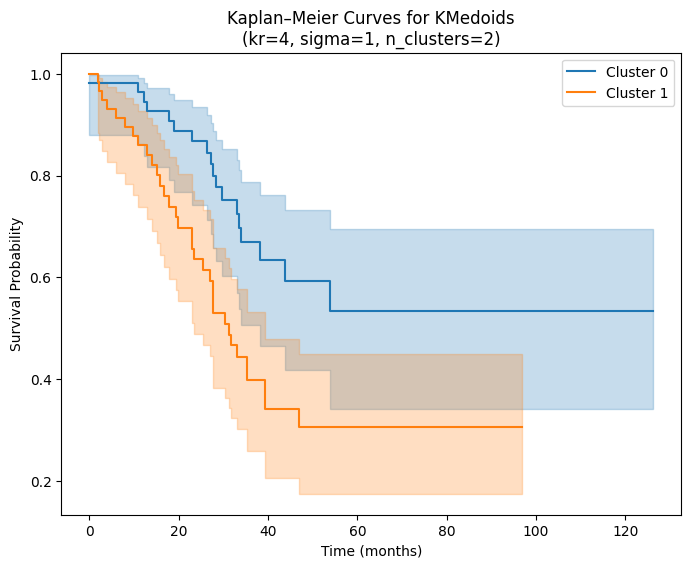

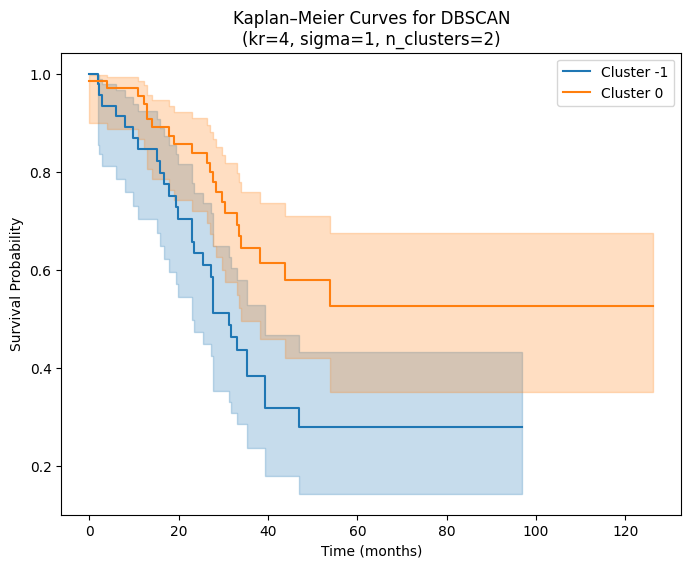

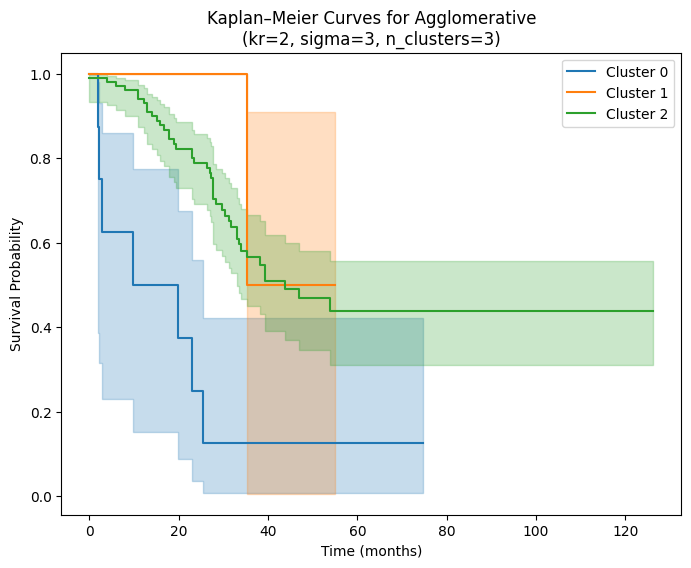

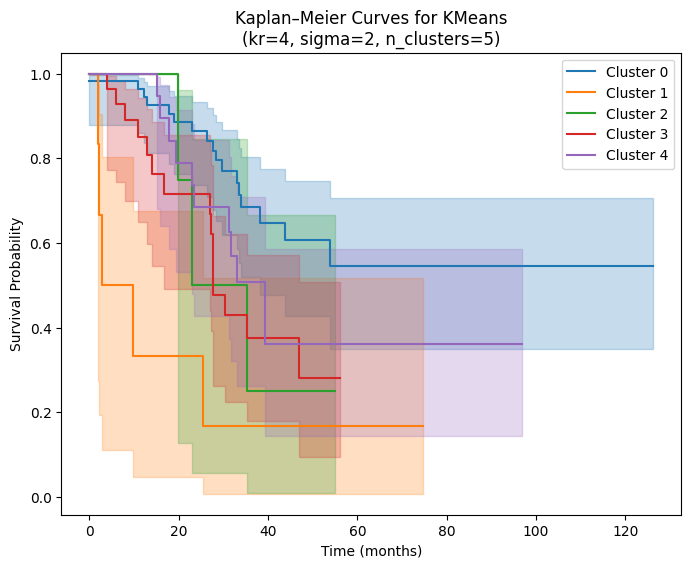

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def kmcurve(method, kr, sigma, n_clusters):
    """
    Plot Kaplan–Meier curves for Overall Survival (OS) for a given clustering configuration.
    
    Parameters:
      method (str): The clustering method (e.g., "Agglomerative", "KMeans", "KMedoids", "DBSCAN").
      kr (int or float): KernelRadius used in the clustering.
      sigma (int or float): Sigma value used in the clustering.
      n_clusters (int): Number of clusters.
      
    The function loads the merged CSV file corresponding to this configuration,
    converts the OS and event indicator columns to numeric, and plots the survival curves
    stratified by the cluster labels from the specified method.
    """
    # Construct file path for the merged CSV file.
    merged_filepath = f"/home/osmirog/1_Projects/Entropic/clustering_results/clustering_results_kRad_{kr}_sigma_{sigma}_nClusters_{n_clusters}.csv"
    try:
        merged_df = pd.read_csv(merged_filepath)
    except Exception as e:
        print(f"Error loading merged file {merged_filepath}: {e}")
        return
    
    # Convert survival columns to numeric.
    merged_df["OS"] = pd.to_numeric(merged_df["OS"], errors="coerce")
    merged_df["Morto =1"] = pd.to_numeric(merged_df["Morto =1"], errors="coerce").fillna(0).astype(int)
    
    # Check that the specified clustering method exists.
    if method not in merged_df.columns:
        print(f"Clustering method '{method}' not found in the merged data.")
        return
    
    # Plot Kaplan–Meier curves.
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))
    unique_clusters = sorted(merged_df[method].unique())
    for cl in unique_clusters:
        sub = merged_df[merged_df[method] == cl]
        if sub.shape[0] < 1:
            continue
        kmf.fit(durations=sub["OS"], event_observed=sub["Morto =1"], label=f"Cluster {cl}")
        kmf.plot_survival_function(ci_show=True)
    
    plt.title(f"Kaplan–Meier Curves for {method}\n(kr={kr}, sigma={sigma}, n_clusters={n_clusters})")
    plt.xlabel("Time (months)")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

# Example usage:

kmcurve("KMedoids", 4, 1, 2)
kmcurve("DBSCAN", 4, 1, 2)

kmcurve("Agglomerative", 2, 3, 3)
kmcurve("KMeans", 4, 2, 5)


In [76]:
import os
import pandas as pd
import gc

from openpyxl import load_workbook

clustering_dir = "/home/osmirog/1_Projects/Entropic/clustering_results"
db_path       = "/home/osmirog/1_Projects/Entropic/DB_AIRCl_Clustering.xlsx"

combos = [
    # Agglomerative
    ("Agglomerative", 2, 3, 3),

    # KMeans
    ("KMeans", 4, 2, 5),
    ("KMedoids", 4, 1, 2),
    ("DBSCAN", 4, 1, 2),
]


# we’ll figure out the “merge key” once:
sample = combos[0]
sample_csv = os.path.join(clustering_dir,
    f"clustering_results_kRad_{sample[1]}_sigma_{sample[2]}_nClusters_{sample[3]}.csv"
)
df_sample = pd.read_csv(sample_csv)
# find first shared column name:
db_cols, cl_cols = set(pd.read_excel(db_path).columns), set(df_sample.columns)
common = db_cols.intersection(cl_cols)
if not common:
    raise RuntimeError("No shared column to merge on!")
KEY = common.pop()
print(f"🔑 merging on: {KEY!r}")

#
# Now: one combo at a time, load the CSV, grab (KEY + cluster_col), and
# append into the existing Excel file using openpyxl to avoid heavyweight
# pandas‐ExcelWriter.
#
from openpyxl import load_workbook

for method, kr, sigma, n_clusters in combos:
    fname = f"clustering_results_kRad_{kr}_sigma_{sigma}_nClusters_{n_clusters}.csv"
    path  = os.path.join(clustering_dir, fname)
    if not os.path.exists(path):
        print(f"⚠️  File not found, skipping: {fname}")
        continue

    df_cl = pd.read_csv(path, usecols=[KEY, method], dtype={method: object})
    newcol = f"{method}_{kr}-{sigma}-{n_clusters}"

    # 1) read workbook and sheet
    wb = load_workbook(db_path)
    ws = wb.active   # or wb["YourSheetName"]

    # 2) write header in row 1, find first empty cell after existing columns
    max_col = ws.max_column
    ws.cell(row=1, column=max_col+1, value=newcol)

    # 3) build a map from KEY -> cluster label
    mapping = dict(zip(df_cl[KEY], df_cl[method]))

    # 4) fill down column (row2 onwards) by looking up the key in column A…Z…
    #    adjust col_idx = max_col+1
    col_idx = max_col + 1
    for row in range(2, ws.max_row+1):
        key_val = ws.cell(row=row, column=1).value
        ws.cell(row=row, column=col_idx).value = mapping.get(key_val, None)

    wb.save(db_path)
    wb.close()
    del df_cl, wb, ws, mapping
    gc.collect()
    print(f"✅  Appended column '{newcol}'")

print("🎉  All done!")



🔑 merging on: 'CODE'
✅  Appended column 'Agglomerative_2-3-3'
✅  Appended column 'KMeans_4-2-5'
✅  Appended column 'KMedoids_4-1-2'
✅  Appended column 'DBSCAN_4-1-2'
🎉  All done!


In [4]:
import os
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

#########################
# Your existing function:
#########################
def run_cox_analysis(filepath, method, time_col, event_col, additional_covariates=None):
    """
    Run a Cox regression model on the merged clinical+clustering data (already on disk).
    """
    df = pd.read_csv(filepath)
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df[event_col] = pd.to_numeric(df[event_col], errors='coerce').fillna(0).astype(int)
    df.dropna(subset=[time_col, event_col], inplace=True)
    
    if method not in df.columns:
        print(f"{method} column not found in {filepath}. Skipping Cox analysis.")
        return None, df
    if df[method].nunique() < 2:
        print(f"Only one unique value in {method} in {filepath}. Skipping Cox analysis.")
        return None, df
    
    df[method] = df[method].astype("category")
    cluster_dummies = pd.get_dummies(df[method], prefix=method, drop_first=True)
    
    final_df = pd.DataFrame(index=df.index)
    final_df[time_col] = df[time_col]
    final_df[event_col] = df[event_col]
    
    for col in cluster_dummies.columns:
        final_df[col] = cluster_dummies[col].astype(float)
    
    if additional_covariates is None:
        additional_covariates = []
        
    processed_covariates = []
    for cov in additional_covariates:
        if cov not in df.columns:
            print(f"Warning: {cov} not found in CSV. Skipping.")
            continue
        
        numeric_series = pd.to_numeric(df[cov], errors='coerce')
        
        if numeric_series.isna().all():
            cat_series = df[cov].astype('category')
            cat_dummies = pd.get_dummies(cat_series, prefix=cov, drop_first=True)
            for dcol in cat_dummies.columns:
                final_df[dcol] = cat_dummies[dcol].astype(float)
        else:
            good_mask = ~numeric_series.isna()
            final_df = final_df[good_mask]  # align both
            numeric_series = numeric_series[good_mask]
            final_df[cov] = numeric_series.astype(float)
        processed_covariates.append(cov)
    
    final_df.dropna(axis=0, inplace=True)
    predictor_cols = [c for c in final_df.columns if c not in [time_col, event_col]]
    
    if len(predictor_cols) == 0:
        print(f"No valid predictors after processing. Cannot fit Cox model for {method}.")
        return None, final_df
    
    cph = CoxPHFitter()
    try:
        cph.fit(final_df[[time_col, event_col] + predictor_cols],
                duration_col=time_col, event_col=event_col)
        print(f"\n=== Cox regression summary for {method} on {time_col} ===")
        cph.print_summary()
        
        ph_test = proportional_hazard_test(cph, final_df, time_transform='rank')
        print(f"\n=== Proportional hazards test summary for {method} on {time_col} ===")
        print(ph_test.summary)
        return cph, final_df
    except Exception as e:
        print(f"Error fitting Cox model for {method} on {time_col}: {e}")
        return None, final_df


def cox_for_combo(
    method: str,
    n_clusters: int,
    sigma: int,
    kernel_radius: int,
    time_col: str = "OS",
    event_col: str = "Morto =1",
    additional_covariates=None,
    base_dir: str = "/home/osmirog/1_Projects/Entropic/clustering_results"
):
    """
    Helper function that constructs the CSV path for the given (kr, sigma, n_clusters),
    then runs run_cox_analysis(...) with the specified method, time_col, and event_col.
    
    Parameters:
      method (str): e.g. "Agglomerative", "KMeans", "KMedoids", or "DBSCAN".
      kernel_radius (int)
      sigma (int)
      n_clusters (int)
      time_col (str): name of the survival time column, e.g. "OS".
      event_col (str): name of the event column, e.g. "Morto =1".
      additional_covariates (list of str): columns like ["AGE", "SEX"] to include in the model.
      base_dir (str): the directory containing your merged CSV files.
      
    Returns:
      cox_model, final_df
        cox_model: CoxPHFitter or None if no model was fit
        final_df: the DataFrame used for fitting
    """
    # 1. Construct the CSV filename
    filename = f"clustering_results_kRad_{kernel_radius}_sigma_{sigma}_nClusters_{n_clusters}.csv"
    filepath = os.path.join(base_dir, filename)
    
    print(f"\n--- Running Cox for {method}, kr={kernel_radius}, sigma={sigma}, n_clusters={n_clusters} ---")
    print(f"CSV path: {filepath}")
    
    # 2. Call the existing function
    cox_model, final_df = run_cox_analysis(
        filepath=filepath,
        method=method,
        time_col=time_col,
        event_col=event_col,
        additional_covariates=additional_covariates
    )
    
    # 3. Return the results
    return cox_model, final_df




In [ ]:
import os
import re
import glob
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

def run_cox_analysis(filepath, method, time_col, event_col, additional_covariates=None, penalizer=1e-3):
    """
    Run a Cox regression model, dropping constant columns and
    adding a small L2 penalty to improve convergence.
    """
    df = pd.read_csv(filepath)
    # Coerce and drop rows with missing time or event
    df[time_col]  = pd.to_numeric(df[time_col], errors='coerce')
    df[event_col] = pd.to_numeric(df[event_col], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=[time_col, event_col]).copy()

    if method not in df.columns or df[method].nunique() < 2:
        print(f"Skipping {method}: insufficient groups.")
        return None, df

    # One‐hot encode cluster membership
    df[method] = df[method].astype("category")
    dummies   = pd.get_dummies(df[method], prefix=method, drop_first=True)
    
    # Build the analysis DataFrame
    analysis_df = pd.DataFrame({
        time_col: df[time_col],
        event_col: df[event_col],
    }, index=df.index)
    analysis_df = pd.concat([analysis_df, dummies], axis=1)

    # Add additional covariates
    for cov in (additional_covariates or []):
        if cov not in df.columns:
            print(f"  [!] {cov} not found, skipping.")
            continue

        series = pd.to_numeric(df[cov], errors='coerce')
        valid = series.notna()
        if valid.sum() == 0:
            # non-numeric: treat as categorical
            cat = df[cov].astype("category")
            cd  = pd.get_dummies(cat, prefix=cov, drop_first=True)
            analysis_df = pd.concat([analysis_df, cd], axis=1)
        else:
            # numeric: align and keep only valid rows
            analysis_df = analysis_df.loc[valid, :]
            analysis_df[cov] = series[valid]

    # Drop any remaining rows with NaN
    analysis_df = analysis_df.dropna()

    # Remove any constant columns (zero variance)
    nunique = analysis_df.nunique()
    const_cols = nunique[nunique <= 1].index
    analysis_df = analysis_df.drop(columns=const_cols, errors='ignore')

    # Final predictors (exclude time & event)
    predictors = [c for c in analysis_df.columns if c not in [time_col, event_col]]
    if not predictors:
        print("  No predictors remain after cleaning. Skipping.")
        return None, analysis_df

    # Fit Cox with a small penalizer
    cph = CoxPHFitter(penalizer=penalizer)
    try:
        cph.fit(analysis_df, duration_col=time_col, event_col=event_col)
        print(f"\n--- Cox summary for {method} on {time_col} ---")
        cph.print_summary()
        
        ph_test = proportional_hazard_test(cph, analysis_df, time_transform='rank')
        print(f"\n--- PH test for {method} on {time_col} ---")
        print(ph_test.summary)
        return cph, analysis_df

    except Exception as e:
        print(f"Error fitting Cox for {method} on {time_col}: {e}")
        return None, analysis_df


def cox_for_combo(
    method, kernel_radius, sigma, n_clusters,
    time_col="OS", event_col="Morto =1",
    base_dir="/home/osmirog/1_Projects/Entropic/clustering_results"
):
    """
    Wrapper to locate the CSV and call run_cox_analysis.
    """
    additional_covariates = [
    "Diam (cm)", "N mtx",
    "Sinc 1/Meta 2", "N",
    # "Sede primitivo (DX=1; SIX=2; Retto=3)",
    "RAS", "BRAF", "Malattia extrahep sinc fegato (0/1)"
]
    fname = f"clustering_results_kRad_{kernel_radius}_sigma_{sigma}_nClusters_{n_clusters}.csv"
    path  = os.path.join(base_dir, fname)
    print(f"\n>>> {method} | kr={kernel_radius}, sigma={sigma}, nClusters={n_clusters}")
    return run_cox_analysis(
        filepath=path,
        method=method,
        time_col=time_col,
        event_col=event_col,
        additional_covariates=additional_covariates
    )



cox_for_combo("KMedoids", 4, 1, 2)
cox_for_combo("DBSCAN", 4, 1, 2)

cox_for_combo("Agglomerative", 2, 3, 3)
cox_for_combo("KMeans", 4, 2, 5)

""" Loop over all hyperparameter combos and methods ---


clustering_dir  = "/home/osmirog/1_Projects/Entropic/clustering_results"
clustering_files = glob.glob(
    os.path.join(clustering_dir, "clustering_results_kRad_*_sigma_*_nClusters_*.csv")
)

# Extract unique (kr, sigma, n_clusters) tuples from filenames
combos = set()
pattern = re.compile(r'kRad_(\d+)_sigma_(\d+)_nClusters_(\d+)')
for fp in clustering_files:
    m = pattern.search(fp)
    if m:
        combos.add(tuple(map(int, m.groups())))

methods = ["Agglomerative", "KMeans", "KMedoids", "DBSCAN"]



for kr, sigma, n_clusters in sorted(combos):
    for method in methods:
        # OS model
        cox_for_combo(
            method=method,
            kernel_radius=kr,
            sigma=sigma,
            n_clusters=n_clusters,
            time_col="OS",
            event_col="Morto =1",
            additional_covariates=additional_covariates,
            base_dir=clustering_dir
        )
        # DFS model
        cox_for_combo(
            method=method,
            kernel_radius=kr,
            sigma=sigma,
            n_clusters=n_clusters,
            time_col="DFS",
            event_col="Recidiva (0/1)",KMedoids
            additional_covariates=additional_covariates,
            base_dir=clustering_dir
        )
"""


>>> KMedoids | kr=4, sigma=1, nClusters=2

--- Cox summary for KMedoids on OS ---


<>:117: SyntaxWarning: invalid escape sequence '\d'
<>:117: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_56930/725669988.py:117: SyntaxWarning: invalid escape sequence '\d'
  """ Loop over all hyperparameter combos and methods ---


<lifelines.CoxPHFitter: fitted with 102 total observations, 57 right-censored observations>
             duration col = 'OS'
                event col = 'Morto =1'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 102
number of events observed = 45
   partial log-likelihood = -173.42
         time fit was run = 2025-04-30 23:41:50 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
KMedoids_1                           0.85      2.33      0.36            0.14            1.55                1.15                4.71
Diam (cm)                            0.01      1.01      0.06           -0.11            0.14                0.89                1.15
N mtx                                0.09      1.10      0.04            0.02            0.16                1.02                1.18
Sinc 1/Meta 2                        0.54      1.72      0.34           -0.12            1.21                0.88                3.34
N                                    0.61      1.84      0.40           -0.18            1.39                0.84                4.02
RAS                                  0.14      1.15      0.33           -0.51            0.79                0.60                2.19
Malattia extrahep sinc fegato (0/1)  0.68      1.97      0.40           -0.11            1.46                0.90                4.32

                                     cmp to    z    p  -log2(p)
covariate                                                      
KMedoids_1                             0.00 2.36 0.02      5.77
Diam (cm)                              0.00 0.19 0.85      0.23
N mtx                                  0.00 2.52 0.01      6.41
Sinc 1/Meta 2                          0.00 1.60 0.11      3.18
N                                      0.00 1.52 0.13      2.95
RAS                                    0.00 0.41 0.68      0.55
Malattia extrahep sinc fegato (0/1)    0.00 1.69 0.09      3.47
---
Concordance = 0.70
Partial AIC = 360.84
log-likelihood ratio test = 21.55 on 7 df
-log2(p) of ll-ratio test = 8.37


--- PH test for KMedoids on OS ---
                                     test_statistic         p  -log2(p)
Diam (cm)                                  0.378997  0.538141  0.893945
KMedoids_1                                 0.174602  0.676054  0.564790
Malattia extrahep sinc fegato (0/1)        0.077151  0.781196  0.356243
N                                          0.025450  0.873250  0.195533
N mtx                                      3.009694  0.082768  3.594785
RAS                                        0.043079  0.835576  0.259157
Sinc 1/Meta 2                              1.946497  0.162965  2.617368

>>> DBSCAN | kr=4, sigma=1, nClusters=2

--- Cox summary for DBSCAN on OS ---


<lifelines.CoxPHFitter: fitted with 102 total observations, 57 right-censored observations>
             duration col = 'OS'
                event col = 'Morto =1'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 102
number of events observed = 45
   partial log-likelihood = -173.96
         time fit was run = 2025-04-30 23:41:51 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
DBSCAN_0                            -0.76      0.47      0.35           -1.45           -0.08                0.23                0.93
Diam (cm)                            0.01      1.01      0.06           -0.11            0.14                0.89                1.15
N mtx                                0.09      1.09      0.04            0.02            0.16                1.02                1.18
Sinc 1/Meta 2                        0.59      1.80      0.34           -0.07            1.25                0.93                3.50
N                                    0.68      1.97      0.40           -0.10            1.46                0.90                4.32
RAS                                  0.10      1.11      0.33           -0.54            0.75                0.58                2.11
Malattia extrahep sinc fegato (0/1)  0.62      1.86      0.39           -0.15            1.39                0.86                4.00

                                     cmp to     z    p  -log2(p)
covariate                                                       
DBSCAN_0                               0.00 -2.18 0.03      5.08
Diam (cm)                              0.00  0.20 0.84      0.25
N mtx                                  0.00  2.49 0.01      6.28
Sinc 1/Meta 2                          0.00  1.74 0.08      3.62
N                                      0.00  1.70 0.09      3.49
RAS                                    0.00  0.31 0.75      0.41
Malattia extrahep sinc fegato (0/1)    0.00  1.58 0.11      3.12
---
Concordance = 0.69
Partial AIC = 361.92
log-likelihood ratio test = 20.47 on 7 df
-log2(p) of ll-ratio test = 7.75


--- PH test for DBSCAN on OS ---
                                     test_statistic         p  -log2(p)
DBSCAN_0                                   0.011336  0.915209  0.127826
Diam (cm)                                  0.638345  0.424311  1.236807
Malattia extrahep sinc fegato (0/1)        0.061437  0.804240  0.314303
N                                          0.039360  0.842737  0.246845
N mtx                                      2.898480  0.088663  3.495522
RAS                                        0.035724  0.850087  0.234317
Sinc 1/Meta 2                              2.079917  0.149248  2.744214

>>> Agglomerative | kr=2, sigma=3, nClusters=3

--- Cox summary for Agglomerative on OS ---


<lifelines.CoxPHFitter: fitted with 102 total observations, 57 right-censored observations>
             duration col = 'OS'
                event col = 'Morto =1'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 102
number of events observed = 45
   partial log-likelihood = -171.19
         time fit was run = 2025-04-30 23:41:51 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
Agglomerative_1                     -2.23      0.11      1.21           -4.60            0.14                0.01                1.15
Agglomerative_2                     -2.26      0.10      0.65           -3.53           -0.98                0.03                0.38
Diam (cm)                           -0.08      0.93      0.07           -0.22            0.07                0.80                1.07
N mtx                                0.09      1.09      0.04            0.02            0.16                1.02                1.17
Sinc 1/Meta 2                        0.52      1.69      0.34           -0.15            1.20                0.86                3.30
N                                    0.58      1.78      0.39           -0.19            1.34                0.83                3.81
RAS                                 -0.11      0.90      0.34           -0.77            0.55                0.46                1.74
Malattia extrahep sinc fegato (0/1)  0.70      2.00      0.41           -0.10            1.49                0.90                4.45

                                     cmp to     z      p  -log2(p)
covariate                                                         
Agglomerative_1                        0.00 -1.84   0.07      3.94
Agglomerative_2                        0.00 -3.46 <0.005     10.86
Diam (cm)                              0.00 -1.05   0.29      1.77
N mtx                                  0.00  2.44   0.01      6.09
Sinc 1/Meta 2                          0.00  1.52   0.13      2.97
N                                      0.00  1.48   0.14      2.85
RAS                                    0.00 -0.32   0.75      0.42
Malattia extrahep sinc fegato (0/1)    0.00  1.71   0.09      3.52
---
Concordance = 0.71
Partial AIC = 358.39
log-likelihood ratio test = 26.00 on 8 df
-log2(p) of ll-ratio test = 9.90


--- PH test for Agglomerative on OS ---
                                     test_statistic         p  -log2(p)
Agglomerative_1                            4.519512  0.033510  4.899248
Agglomerative_2                            4.691643  0.030310  5.044079
Diam (cm)                                  2.095997  0.147685  2.759402
Malattia extrahep sinc fegato (0/1)        0.132748  0.715600  0.482775
N                                          0.410398  0.521767  0.938521
N mtx                                      1.808756  0.178658  2.484731
RAS                                        0.612284  0.433929  1.204468
Sinc 1/Meta 2                              2.903505  0.088387  3.500019

>>> KMeans | kr=4, sigma=2, nClusters=5

--- Cox summary for KMeans on OS ---


<lifelines.CoxPHFitter: fitted with 102 total observations, 57 right-censored observations>
             duration col = 'OS'
                event col = 'Morto =1'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 102
number of events observed = 45
   partial log-likelihood = -169.16
         time fit was run = 2025-04-30 23:41:51 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
KMeans_1                             2.76     15.78      0.76            1.27            4.25                3.56               69.85
KMeans_2                             1.50      4.47      0.68            0.17            2.83                1.18               16.91
KMeans_3                             1.10      2.99      0.41            0.29            1.90                1.34                6.66
KMeans_4                             0.60      1.83      0.47           -0.32            1.52                0.73                4.58
Diam (cm)                           -0.08      0.92      0.07           -0.22            0.06                0.80                1.06
N mtx                                0.08      1.08      0.04            0.01            0.15                1.01                1.17
Sinc 1/Meta 2                        0.58      1.78      0.34           -0.10            1.25                0.91                3.49
N                                    0.63      1.87      0.41           -0.17            1.42                0.84                4.16
RAS                                  0.03      1.03      0.35           -0.66            0.72                0.52                2.06
Malattia extrahep sinc fegato (0/1)  1.01      2.75      0.43            0.16            1.86                1.18                6.41

                                     cmp to     z      p  -log2(p)
covariate                                                         
KMeans_1                               0.00  3.63 <0.005     11.81
KMeans_2                               0.00  2.20   0.03      5.19
KMeans_3                               0.00  2.68   0.01      7.08
KMeans_4                               0.00  1.28   0.20      2.32
Diam (cm)                              0.00 -1.16   0.25      2.02
N mtx                                  0.00  2.18   0.03      5.09
Sinc 1/Meta 2                          0.00  1.67   0.09      3.41
N                                      0.00  1.53   0.13      3.00
RAS                                    0.00  0.09   0.93      0.11
Malattia extrahep sinc fegato (0/1)    0.00  2.34   0.02      5.68
---
Concordance = 0.73
Partial AIC = 358.33
log-likelihood ratio test = 30.06 on 10 df
-log2(p) of ll-ratio test = 10.22


--- PH test for KMeans on OS ---
                                     test_statistic         p  -log2(p)
Diam (cm)                                  1.561919  0.211384  2.242059
KMeans_1                                   6.508891  0.010734  6.541716
KMeans_2                                   0.025393  0.873392  0.195298
KMeans_3                                   0.411547  0.521185  0.940132
KMeans_4                                   0.091399  0.762406  0.391369
Malattia extrahep sinc fegato (0/1)        0.373872  0.540901  0.886563
N                                          0.064124  0.800092  0.321762
N mtx                                      3.090818  0.078735  3.666847
RAS                                        0.916400  0.338422  1.563104
Sinc 1/Meta 2                              2.100053  0.147294  2.763229


' Loop over all hyperparameter combos and methods ---\n\n\nclustering_dir  = "/home/osmirog/1_Projects/Entropic/clustering_results"\nclustering_files = glob.glob(\n    os.path.join(clustering_dir, "clustering_results_kRad_*_sigma_*_nClusters_*.csv")\n)\n\n# Extract unique (kr, sigma, n_clusters) tuples from filenames\ncombos = set()\npattern = re.compile(r\'kRad_(\\d+)_sigma_(\\d+)_nClusters_(\\d+)\')\nfor fp in clustering_files:\n    m = pattern.search(fp)\n    if m:\n        combos.add(tuple(map(int, m.groups())))\n\nmethods = ["Agglomerative", "KMeans", "KMedoids", "DBSCAN"]\n\n\n\nfor kr, sigma, n_clusters in sorted(combos):\n    for method in methods:\n        # OS model\n        cox_for_combo(\n            method=method,\n            kernel_radius=kr,\n            sigma=sigma,\n            n_clusters=n_clusters,\n            time_col="OS",\n            event_col="Morto =1",\n            additional_covariates=additional_covariates,\n            base_dir=clustering_dir\n        )\n